In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

def read_csv(file_loc: str) -> pd.DataFrame:
    return pd.read_csv(file_loc, true_values=["resolved"], false_values=["floor"], na_values=[''])

df = pd.concat([read_csv("file_3_Mar18_Output_1.csv"), read_csv("file_3_Mar18_Output_1.csv")], ignore_index=True)

In [134]:
df["account_open_date_13_march"] = pd.to_datetime(df["account_open_date_13_march"])
df["account_open_date_18_march"] = pd.to_datetime(df["account_open_date_18_march"])

# Cleanup
df[["delinquency_history_13_march_present", "delinquency_history_18_march_present"]] = df[["delinquency_history_13_march", "delinquency_history_18_march"]].map(lambda x: int(str(x)[1]))
df[["delinquency_history_13_march_past", "delinquency_history_18_march_past"]] = df[["delinquency_history_13_march", "delinquency_history_18_march"]].map(lambda x: int(str(x)[2]))
df[["ebill_enrolled_status_13_march", "ebill_enrolled_status_18_march"]] =  df[["ebill_enrolled_status_13_march", "ebill_enrolled_status_18_march"]].fillna("NA").replace(r"^\s*$", "NA", regex=True)
df[["account_status_13_march", "account_status_18_march"]] =  df[["account_status_13_march", "account_status_18_march"]].fillna("NA").replace(r"^\s*$", "NA", regex=True)
df[["card_activation_status_13_march", "card_activation_status_18_march"]] = df[["card_activation_status_13_march", "card_activation_status_18_march"]].fillna(-1).replace(r"^\s*$", -1, regex=True)
min_date = min(min(df["account_open_date_13_march"]), min(df["account_open_date_18_march"]))
df["account_open_date_13_march"] = np.log((df["account_open_date_13_march"] - min_date).astype('int64') + 1)
df["account_open_date_18_march"] = np.log((df["account_open_date_18_march"] - min_date).astype('int64') + 1)
df[["day", "time_of_day"]] = df["timestamp_call_key"].str.split(" ").str[0].str.extract(r'(\d{6})(\d{6})')

# add mos in order
col_names = [f"mos{i}" for i in range(1, len(max(df["mos"], key=lambda x: len(x.split()))) // 3 + 2)]
split_mos = df["mos"].str.split(expand=True)
split_mos = split_mos.fillna("NA")
split_mos.columns = col_names[:len(split_mos.columns)]

# transform reasons/mos
reason_encoder = LabelEncoder()
reason_encoder = reason_encoder.fit(["AA", "AG", "AL", "AP", "AR", "AS", "AT", "AU", "BA", "Ba", "BL", "CA", "CB", "CC",
"CD", "CS", "CT", "CX", "DA", "DB", "DE", "DP", "DR", "DS", "eA", "eB", "EB", "eL", "eP", "eR", "ER", "eS", "eY", "FB", "FD",
"FI", "FM", "GA", "HI", "iA", "IA", "iB", "iC", "IC", "IE", "iF", "iL", "iM", "iO", "iP", "IR", "iR", "iS", "iT", "IV","LC",
"LM", "LS", "Ls", "LW", "m-", "ma", "me", "MF", "mm", "mn", "mo", "mp", "MP", "Mr", "MR", "mt", "nl", "NU", "OB", "OC", "OI", "OO",
"OR", "OV", "PA", "PC", "Pd", "PF", "PH", "PI", "PO", "PP", "PR", "PS", "PT", "PV", "PX", "Py", "RC", "RI", "RP", "RS", "RV", "SA",
"SP", "SR", "ss", "ST", "Ta", "TA", "TB", "TC", "TD", "Te", "TE", "Tf", "TF", "TL", "TN", "TP", "TR", "TS", "TU", "UP", "VP", "VR",
"WA", "wa", "rP", "P1", "P2", "S1", "S2", "S3", "P3", "C1", "C2", "P4", "P5", "P6", "rT", "T1", "A1", "A2", "T2", "T3", "D1", "D2",
"D3", "D4", "FR", "PD", "OL", "NO", "XR", "VA", "mP", "AM", "NA"])
df["reason"] = reason_encoder.transform(df["reason"])
for col in split_mos.columns:
    split_mos[col] = reason_encoder.transform(split_mos[col])

df = pd.concat([df, split_mos], axis=1)

# transform account status
external_status_encoder = LabelEncoder()
encoded_status_codes = external_status_encoder.fit_transform(df["account_status_18_march"])
df["account_status_18_march"] = encoded_status_codes
df["account_status_13_march"] = encoded_status_codes

# transform ebill status
ebill_encoder = LabelEncoder()
encoded_ebill_status = ebill_encoder.fit_transform(df["ebill_enrolled_status_18_march"])
df["ebill_enrolled_status_18_march"] = encoded_ebill_status
df["ebill_enrolled_status_13_march"] = encoded_ebill_status

df = df.drop(["delinquency_history_13_march", "delinquency_history_18_march"], axis=1)
df

,timestamp_call_key,retailer_code,serial,reason,mos,resolved,no_of_accounts_with_syf_13_march,account_balance_13_march,account_open_date_13_march,account_status_13_march,...,mos2,mos3,mos4,mos5,mos6,mos7,mos8,mos9,mos10,mos11
0,240315173250 DAL1OA3M,D,10010009499,79,IA PP TR,True,1.0,NaN,42.040285,7,...,79,111,56,56,56,56,56,56,56,56
1,240315124742 DAL15XHK,E,10006021998,11,IA BA TS nl TR,False,2.0,143.28,41.856014,7,...,11,112,150,111,56,56,56,56,56,56
2,240317114237 DAL3BLK6,J,10016007830,82,IA AA BA MR nl PT TR,True,12.0,0.00,42.112479,7,...,2,11,54,150,82,111,56,56,56,56
3,240314120849 PHX6PL4U,E,10008003199,11,IA BA,True,2.0,44.98,42.211587,7,...,11,56,56,56,56,56,56,56,56,56
4,240314145902 DAL68RYS,I,10013002037,11,IA BA TS nl mm TR,False,6.0,7.00,42.180308,7,...,11,112,150,145,111,56,56,56,56,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809261,240315165941 PHX67C7R,E,10008016957,82,IA BA nl PT TR,True,6.0,4431.60,41.924628,3,...,11,150,82,111,56,56,56,56,56,56
1809262,240315180137 PHX2GWK4,B,10002066257,11,IA PP BA,True,3.0,100.54,42.193453,7,...,79,11,56,56,56,56,56,56,56,56
1809263,240314142306 DAL33PKW,E,10008004931,11,IA BA,True,2.0,2504.35,42.204972,7,...,11,56,56,56,56,56,56,56,56,56
1809264,240314141352 DAL64P9X,F,10009002991,79,IA IA PP TR,True,5.0,2934.35,42.188158,7,...,42,79,111,56,56,56,56,56,56,56


In [93]:
df.dropna().describe()

,no_of_accounts_with_syf_13_march,account_balance_13_march,account_open_date_13_march,eservice_ind_13_march,auto_pay_enrolled_status_13_march,no_of_accounts_with_syf_18_march,account_balance_18_march,account_open_date_18_march,eservice_ind_18_march,auto_pay_enrolled_status_18_march,delinquency_history_13_march_present,delinquency_history_13_march_past,delinquency_history_18_march_present,delinquency_history_18_march_past
count,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06,1.669806e+06
mean,5.099463e+00,1.177640e+03,4.212144e+01,4.276377e-01,1.589406e-02,5.109123e+00,1.181172e+03,4.212144e+01,4.315783e-01,1.602821e-02,9.889053e-02,9.001884e-02,9.845575e-02,9.204303e-02
std,3.609405e+00,1.794959e+03,1.467186e-01,4.947361e-01,1.250658e-01,3.613249e+00,1.800826e+03,1.467186e-01,4.952965e-01,1.255839e-01,4.755070e-01,4.656726e-01,4.713918e-01,4.698621e-01
min,1.000000e+00,-2.302494e+04,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-2.302494e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,1.141600e+02,4.209411e+01,0.000000e+00,0.000000e+00,2.000000e+00,1.152700e+02,4.209411e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.000000e+00,4.660800e+02,4.215846e+01,0.000000e+00,0.000000e+00,4.000000e+00,4.678200e+02,4.215846e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,7.000000e+00,1.478030e+03,4.219099e+01,1.000000e+00,0.000000e+00,7.000000e+00,1.483247e+03,4.219099e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.210000e+02,4.000043e+04,4.221291e+01,1.000000e+00,1.000000e+00,1.210000e+02,4.000043e+04,4.221291e+01,1.000000e+00,1.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00


In [5]:
agg = df.groupby(["resolved"])
agg.groups


{False: [1, 4, 5, 10, 17, 18, 23, 29, 37, 38, 42, 44, 57, 62, 71, 92, 105, 119, 129, 138, 142, 143, 147, 154, 155, 160, 165, 168, 176, 178, 194, 196, 198, 200, 202, 203, 223, 232, 235, 240, 242, 243, 244, 247, 256, 261, 267, 276, 283, 284, 290, 291, 302, 305, 324, 326, 327, 330, 332, 348, 350, 356, 358, 360, 361, 380, 386, 396, 397, 398, 405, 406, 408, 409, 436, 439, 440, 441, 443, 447, 450, 453, 455, 459, 460, 468, 476, 481, 482, 487, 491, 495, 509, 513, 516, 538, 541, 542, 560, 561, ...], True: [0, 2, 3, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, ...]}

In [6]:
agg_mean = agg.mean(numeric_only=True)
agg_mean

,no_of_accounts_with_syf_13_march,account_balance_13_march,eservice_ind_13_march,auto_pay_enrolled_status_13_march,no_of_accounts_with_syf_18_march,account_balance_18_march,eservice_ind_18_march,auto_pay_enrolled_status_18_march,delinquency_history_13_march_present,delinquency_history_13_march_past,delinquency_history_18_march_present,delinquency_history_18_march_past
resolved,,,,,,,,,,,,
False,5.038822,1072.813477,0.534838,0.025581,5.068230,1073.016551,0.547985,0.025982,0.147994,0.112192,0.154707,0.113730
True,5.121691,1201.706999,0.402626,0.013597,5.127247,1202.863276,0.405509,0.013672,0.086297,0.083538,0.084214,0.085556


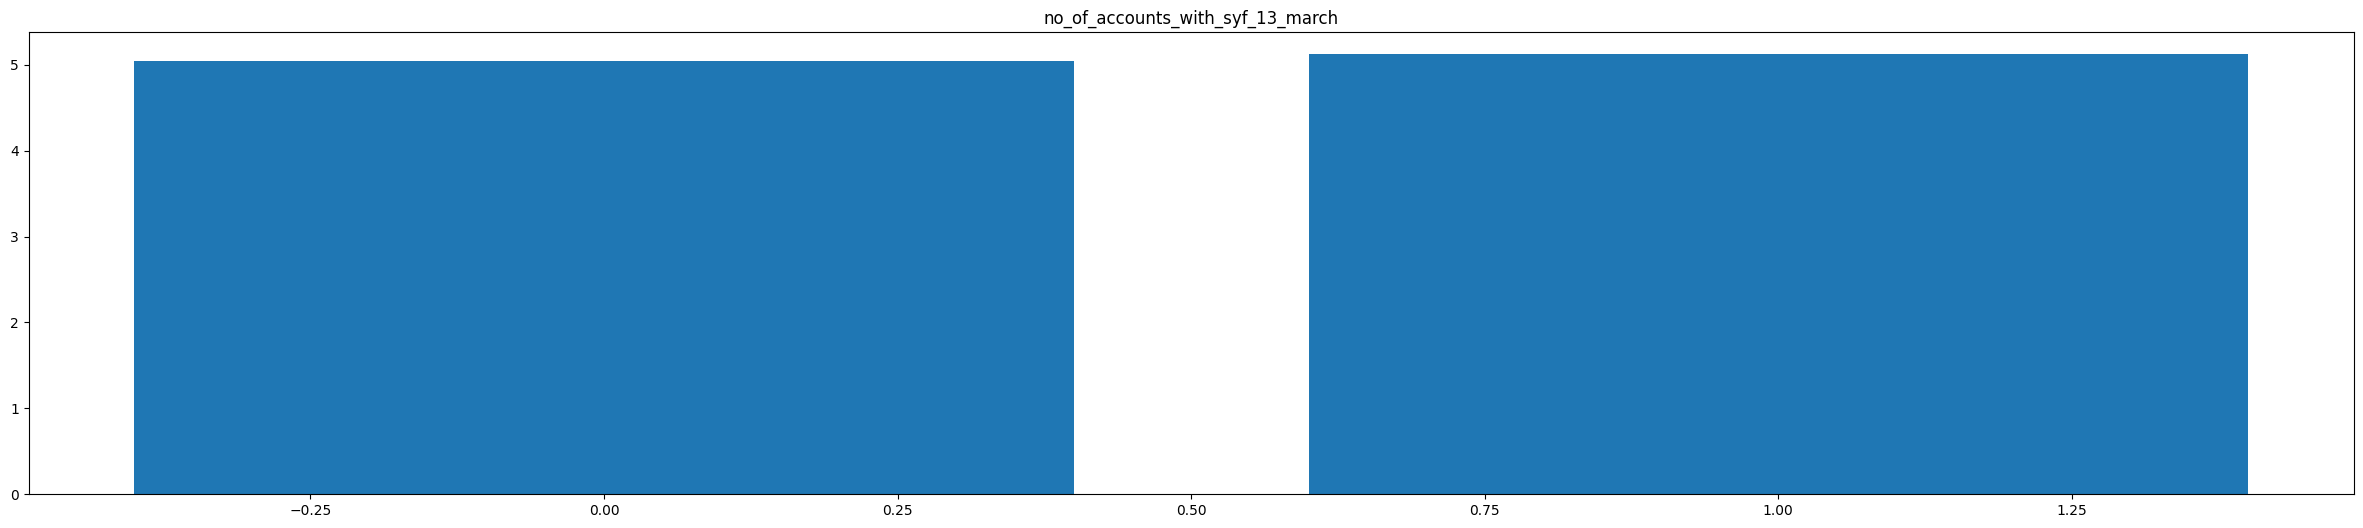

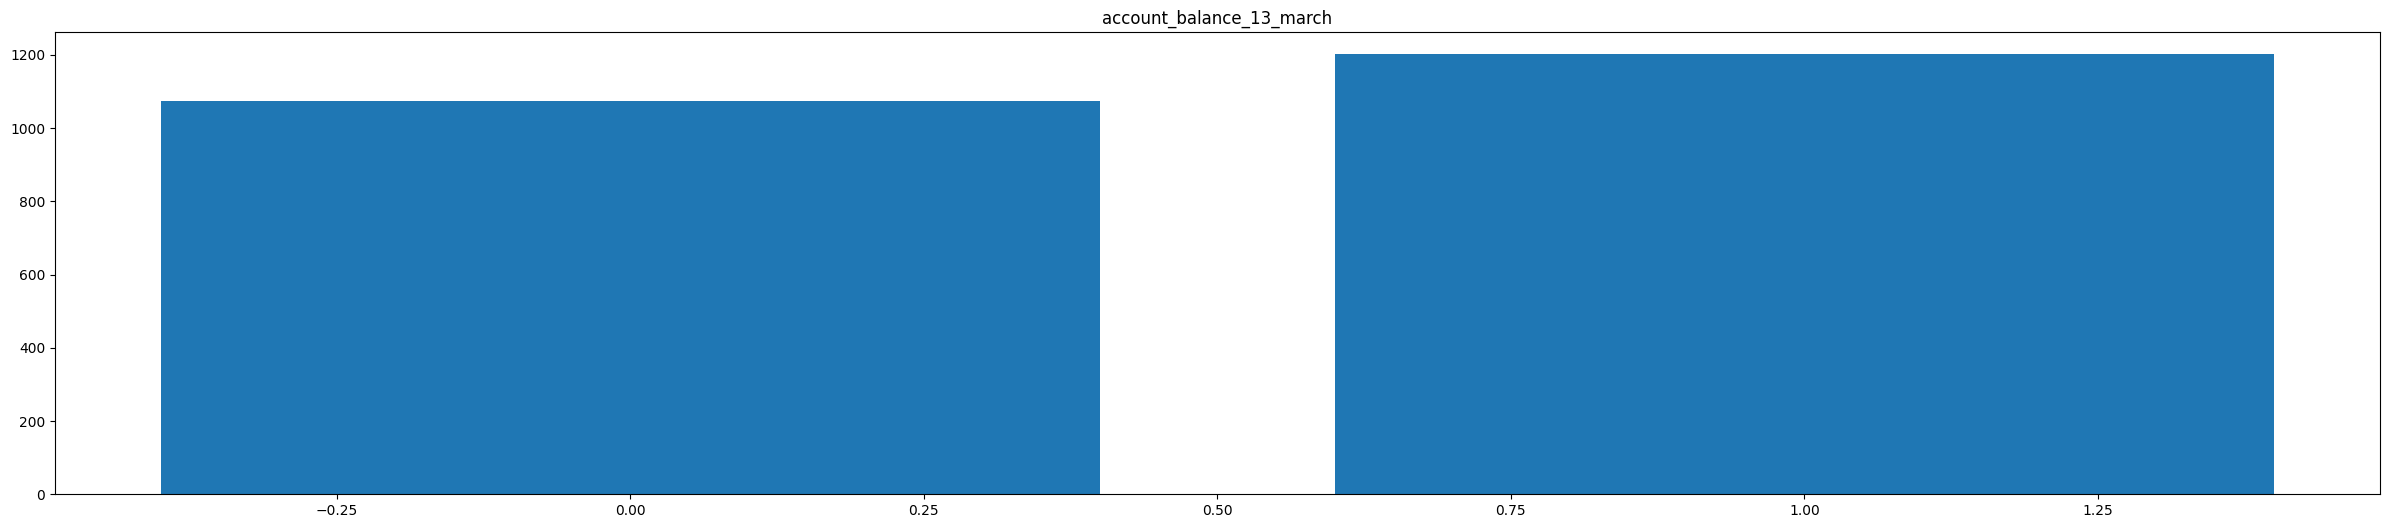

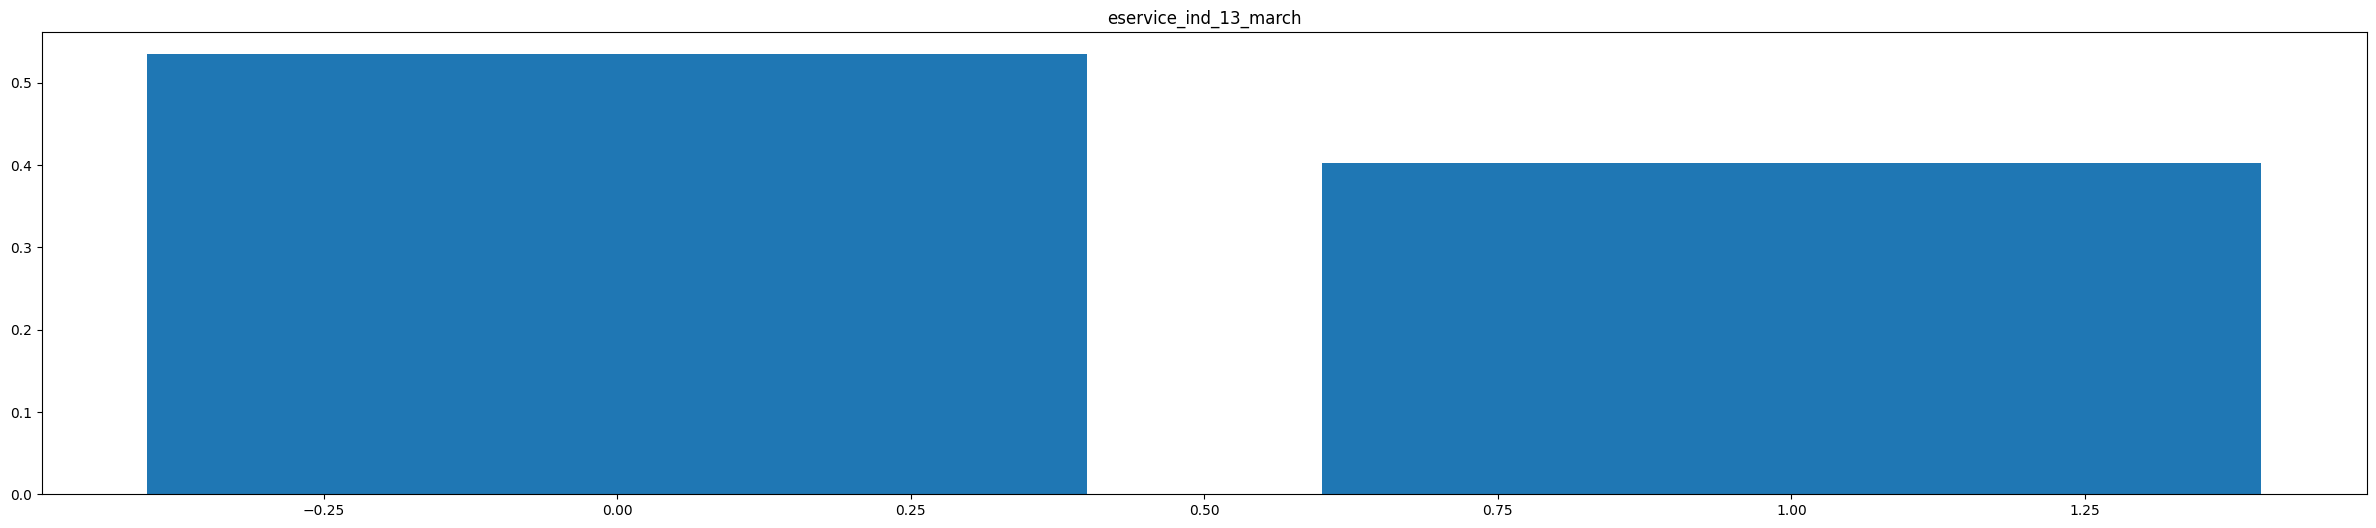

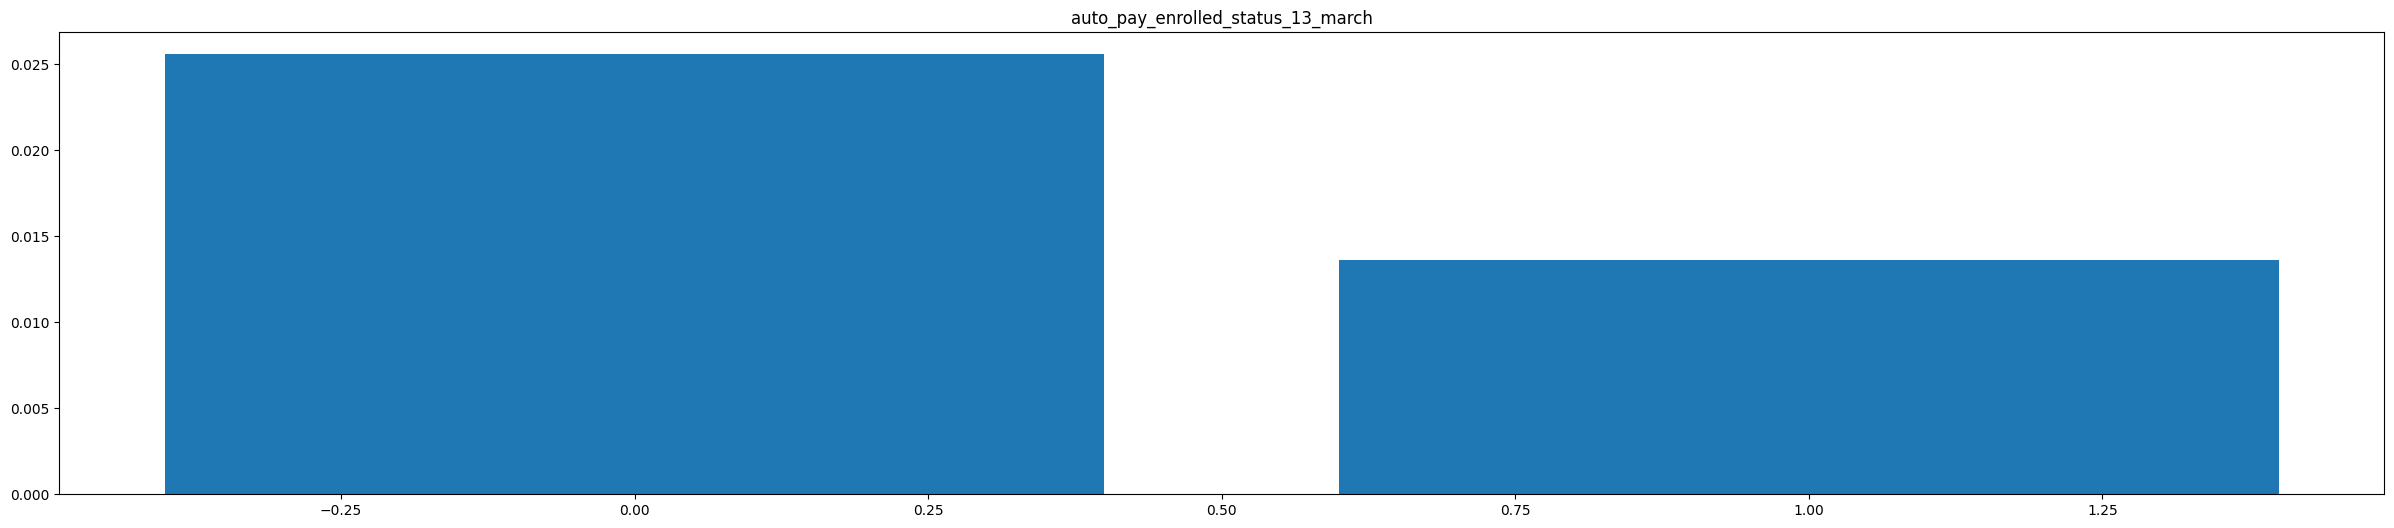

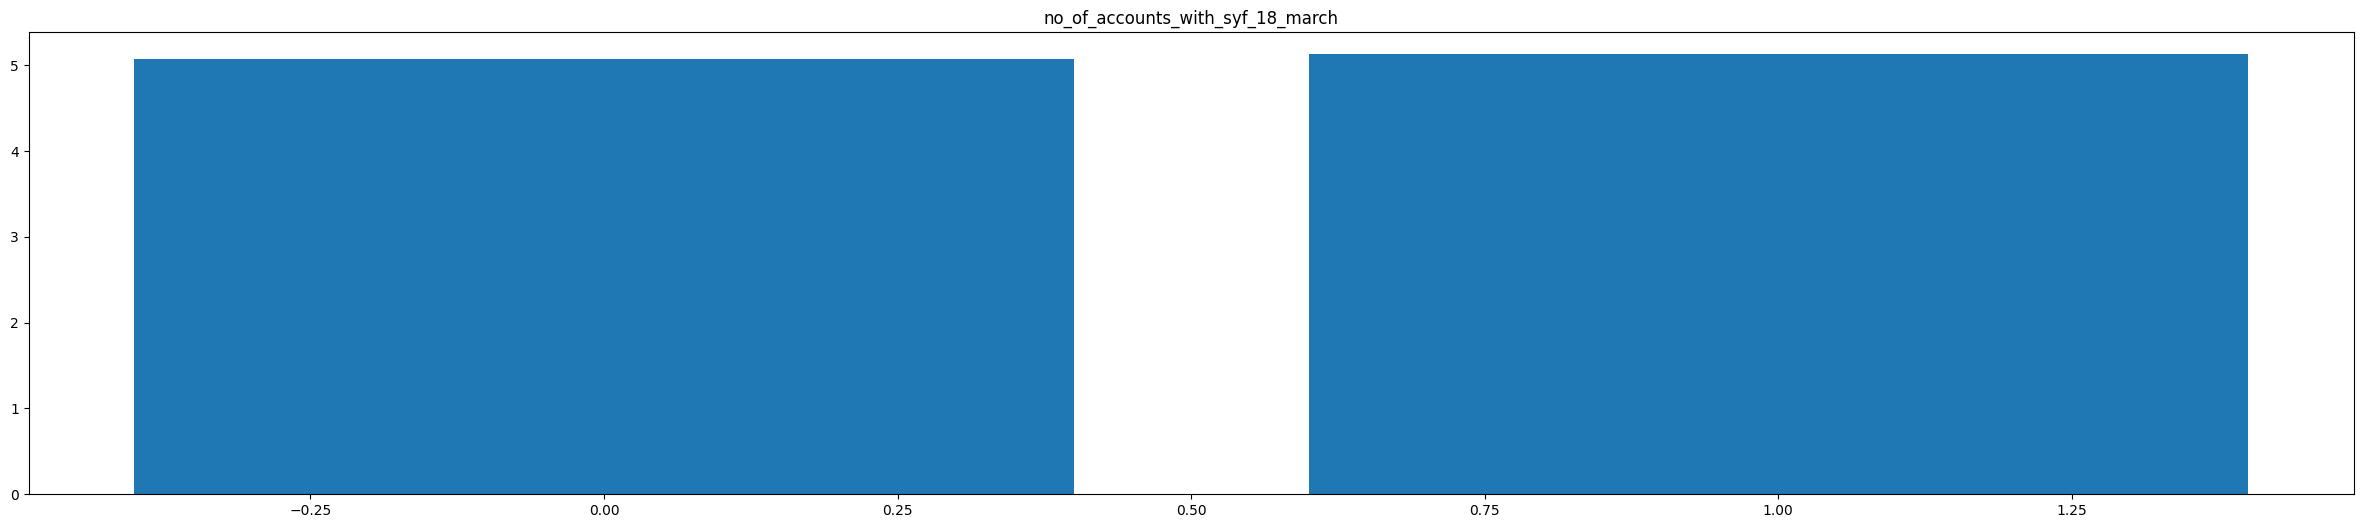

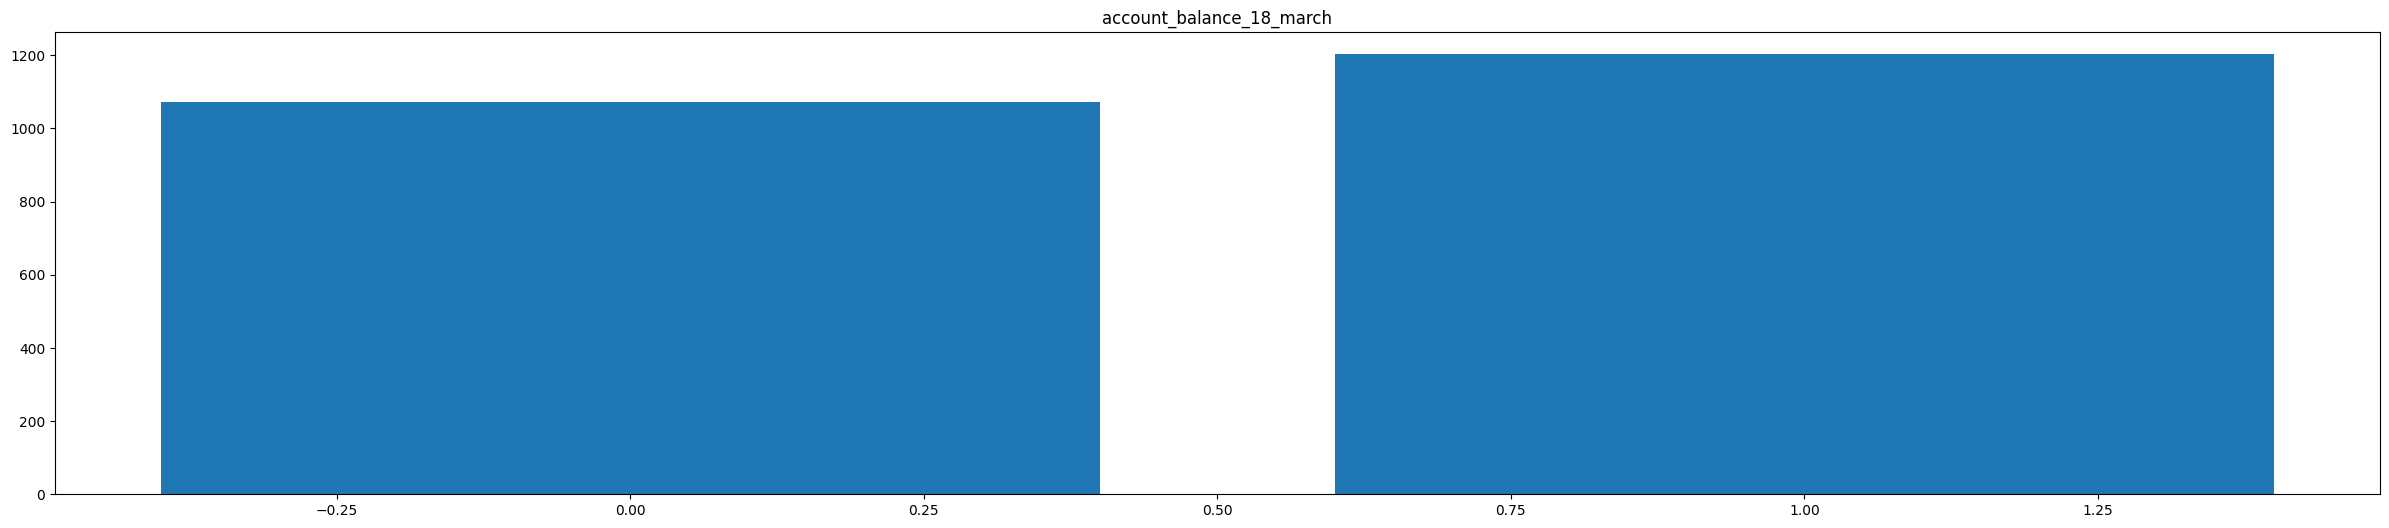

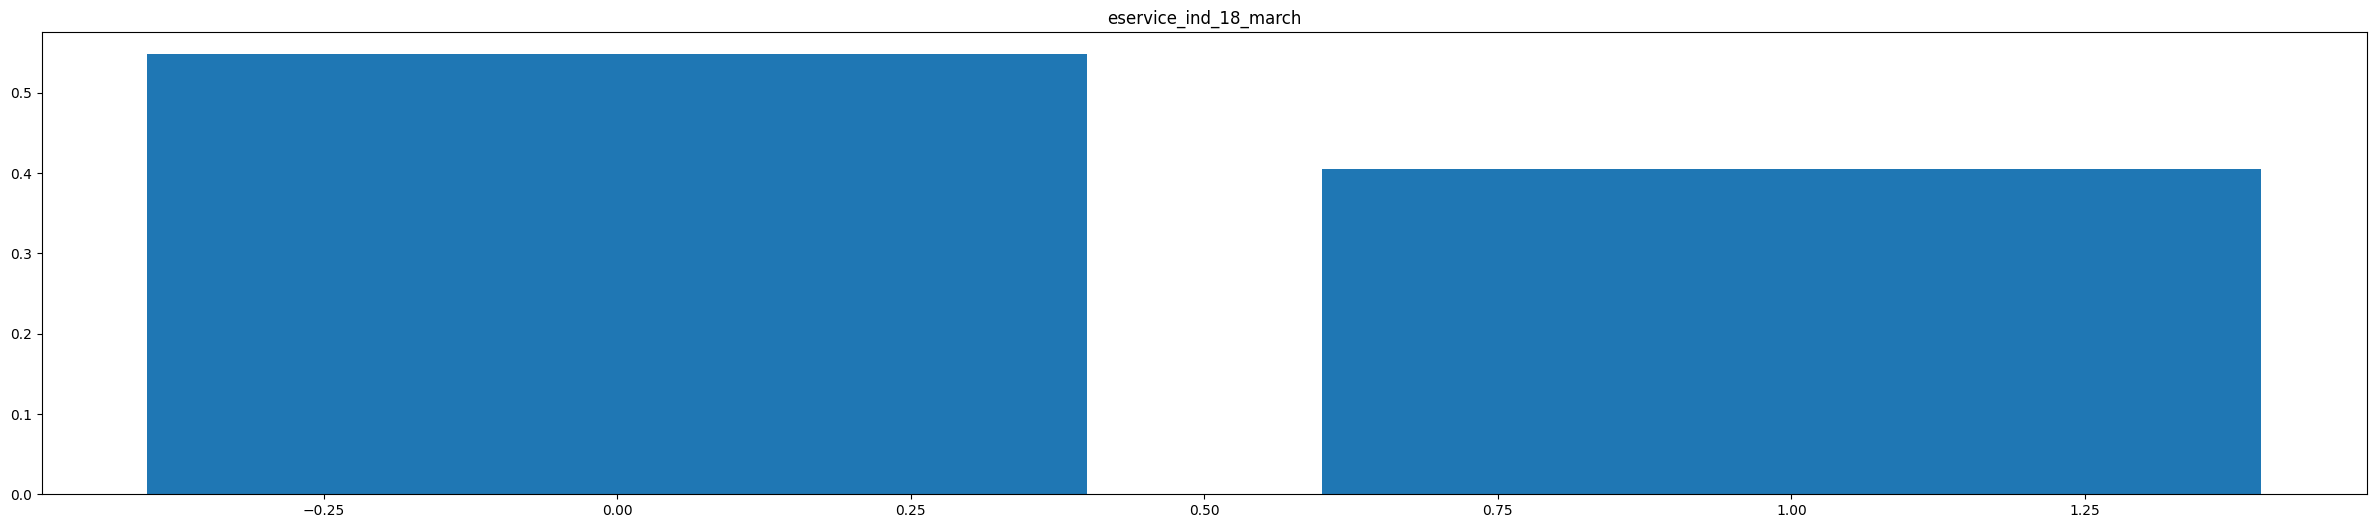

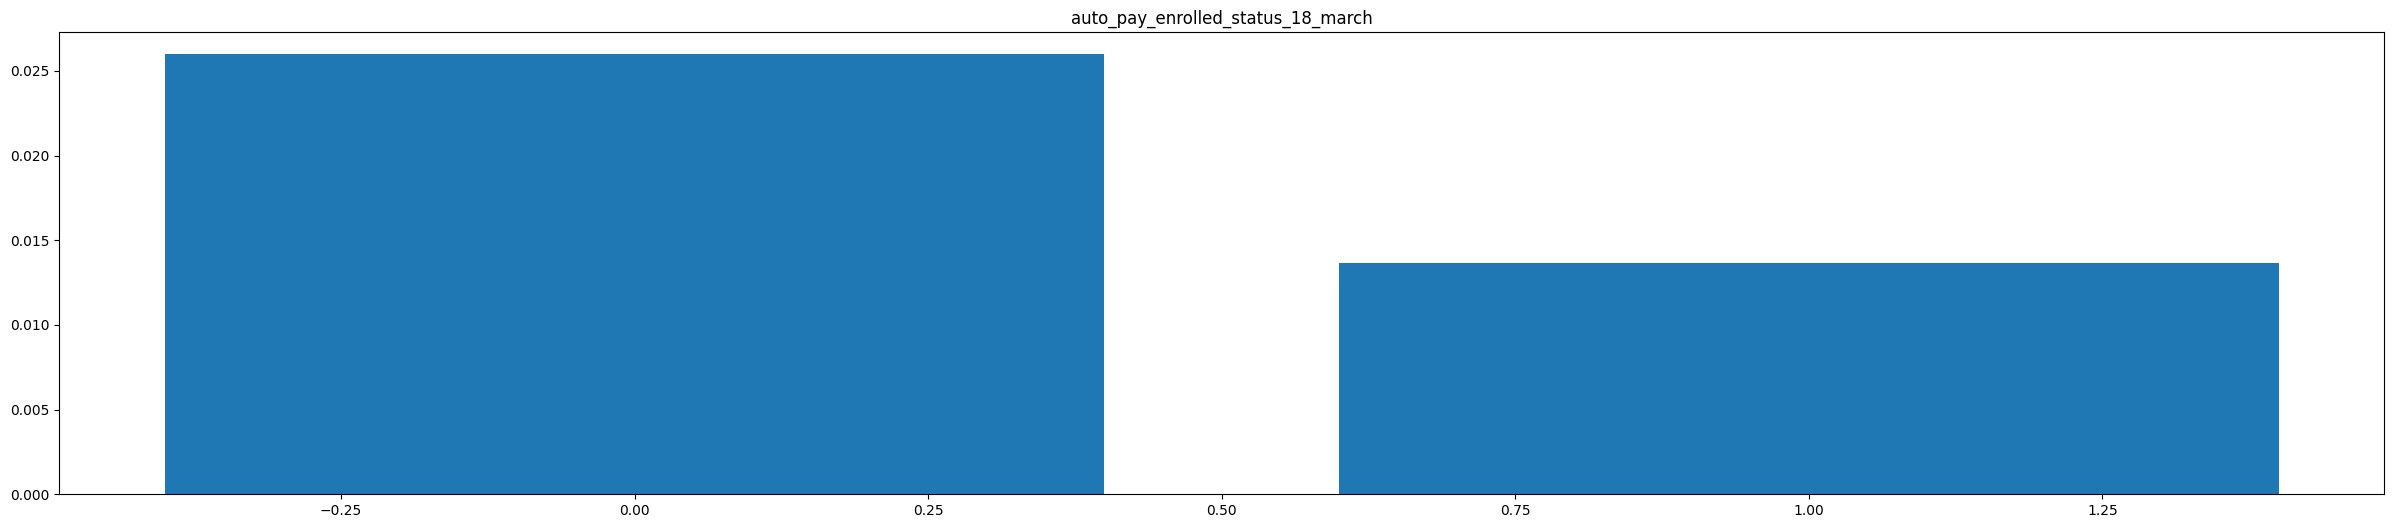

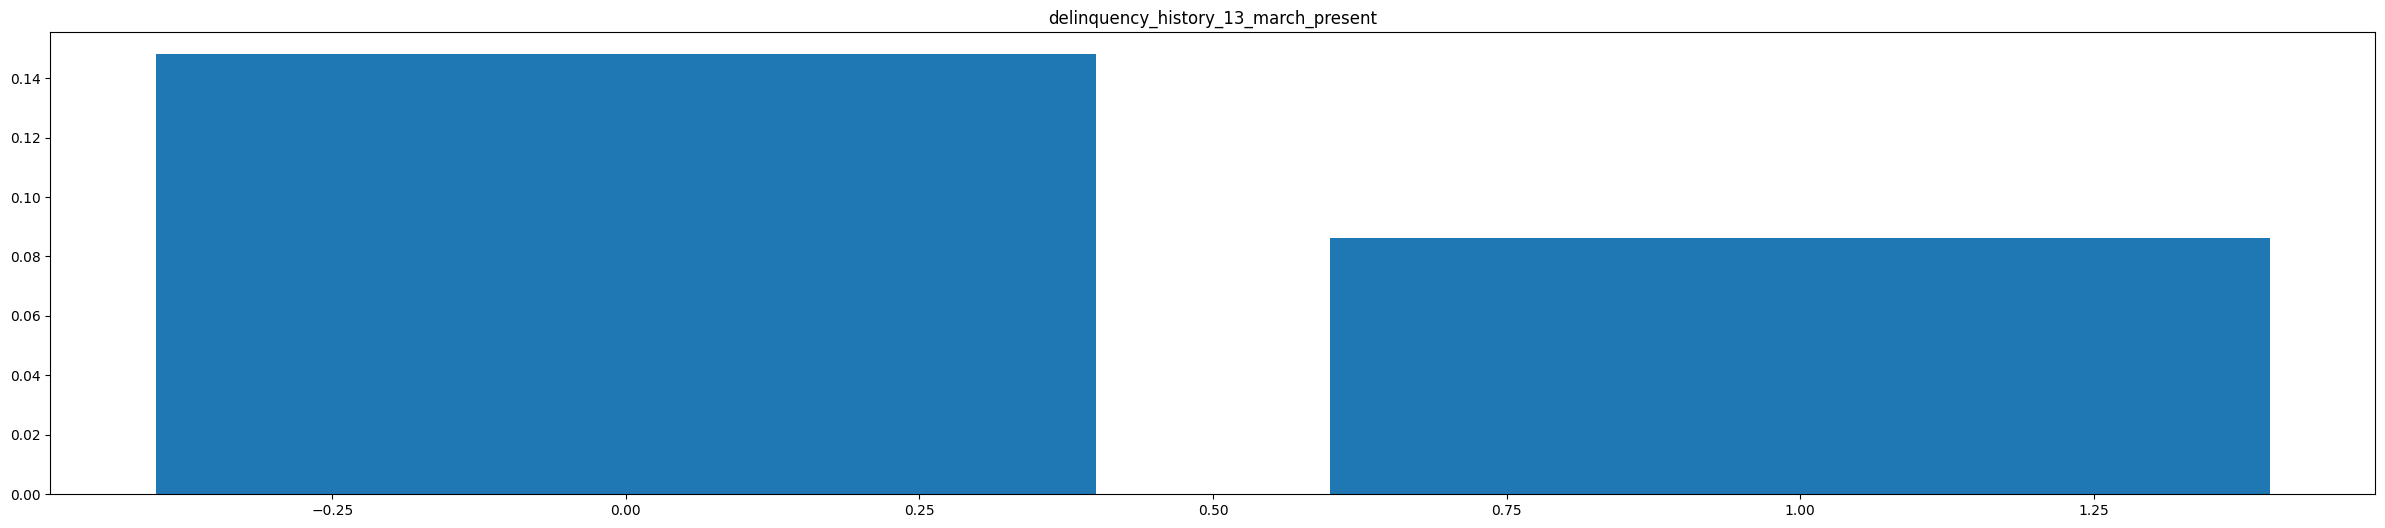

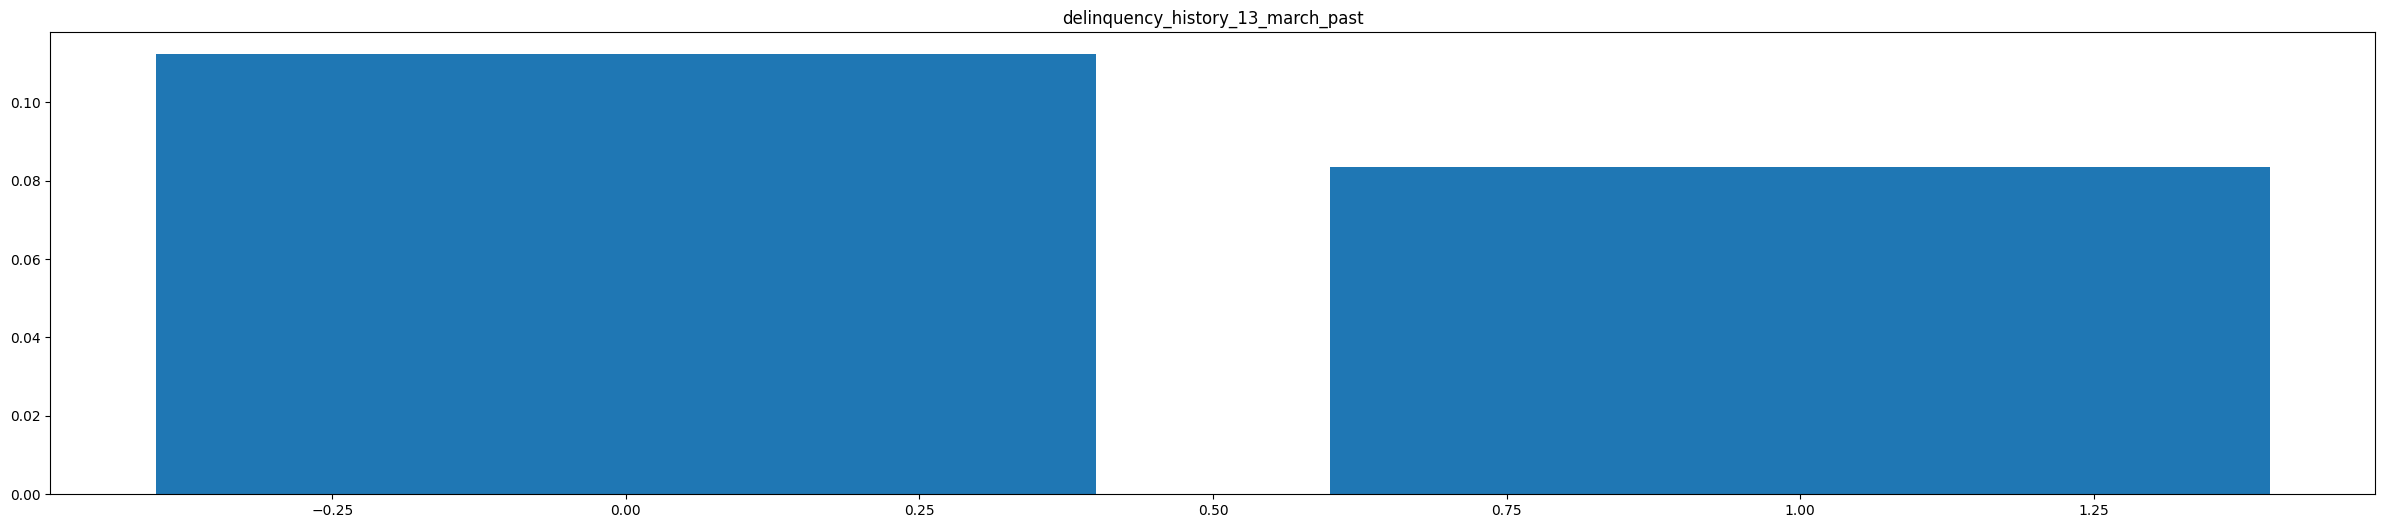

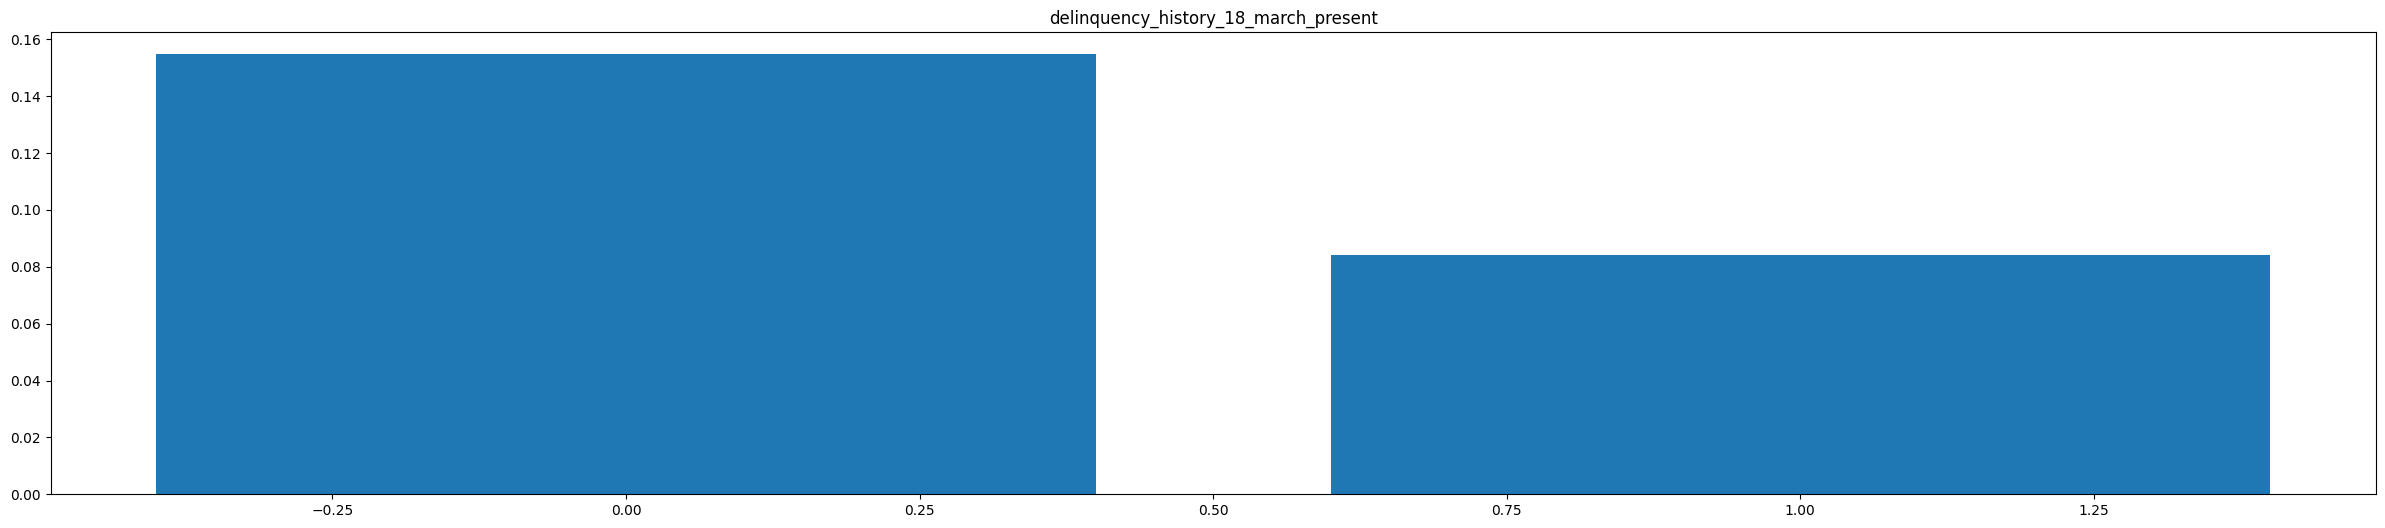

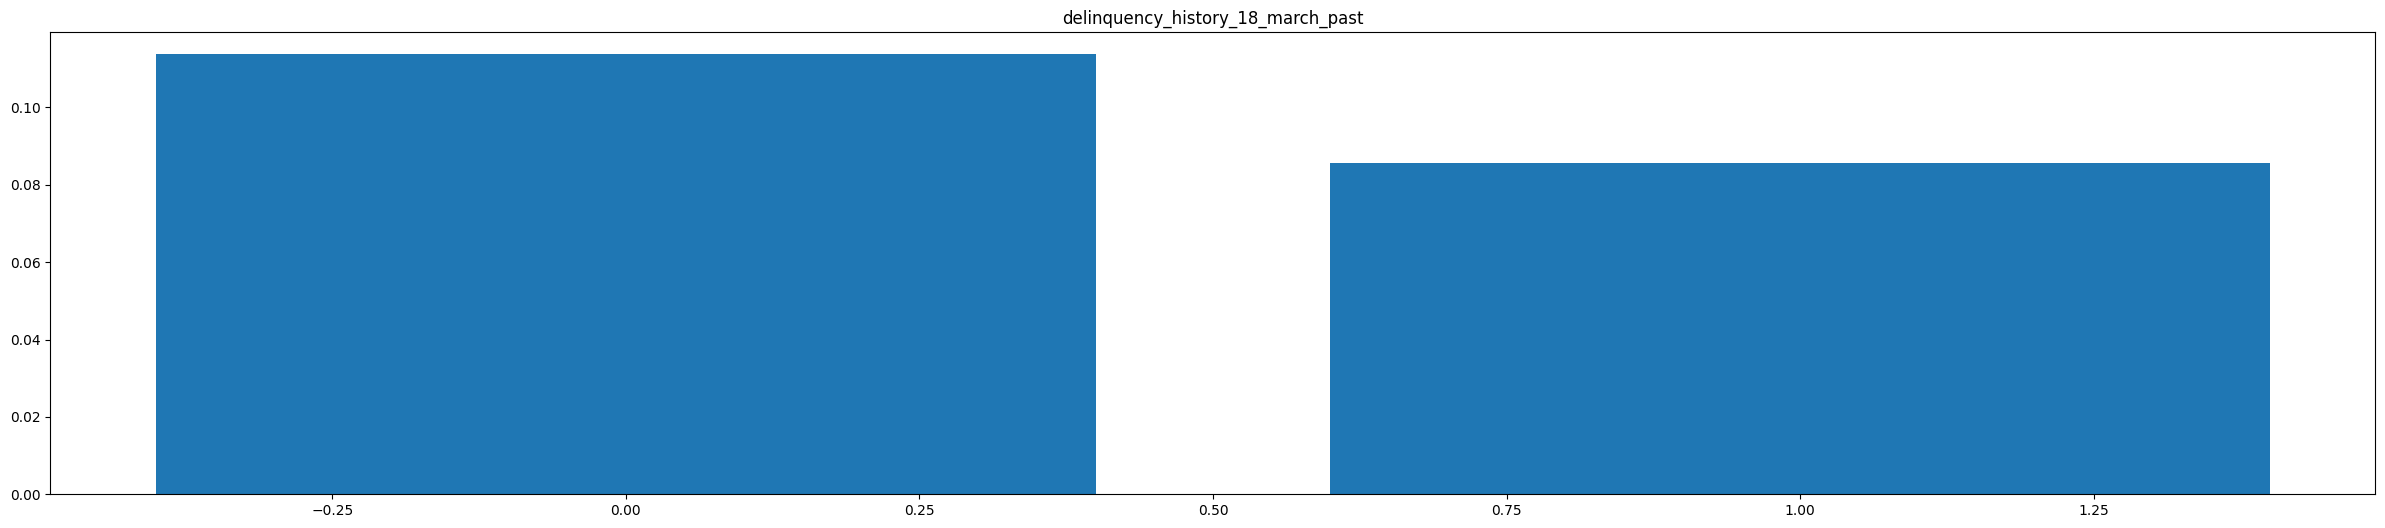

In [7]:
# indices = [f"{index[0]}, {index[1]}" for index in agg_mean.index]
indices = agg_mean.index
for col in agg_mean.columns:
    plt.figure( figsize=(30, 6))
    plt.title(col)
    plt.bar(indices, agg_mean[col])

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [136]:
df = df.drop(["timestamp_call_key", "retailer_code", "mos", "serial"], axis=1)
X = df.drop('resolved', axis=1)
y = df['resolved']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [137]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [138]:
feature_importances = rf_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
28,mos6,0.135582
0,reason,0.115561
27,mos5,0.110822
29,mos7,0.100009
30,mos8,0.072359
26,mos4,0.054282
22,time_of_day,0.045394
31,mos9,0.040531
24,mos2,0.039017
25,mos3,0.034966


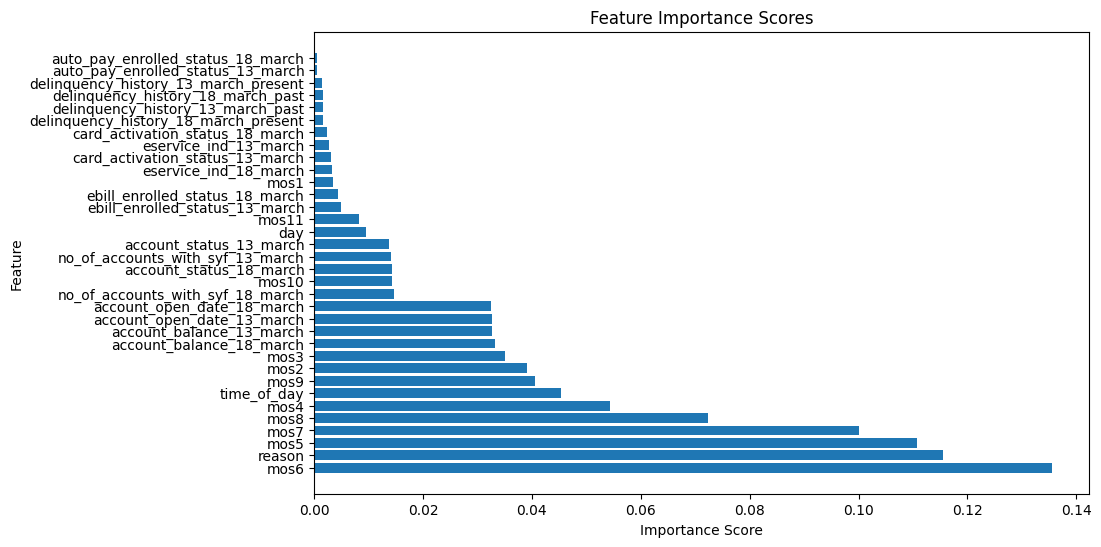

In [139]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance Scores')
plt.show()